# Penguin Perceptron!
<img src="https://imgur.com/orZWHly.png" width=500>

## Dataset

In [1]:
# # clean example
# species_tup = 'Adelie', 'Gentoo'
# x_feat = ['bill_depth_mm', 'flipper_length_mm']

# tough example
species_tup = 'Chinstrap', 'Gentoo'
x_feat = ['body_mass_g', 'flipper_length_mm']

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)

df = sns.load_dataset('penguins')

df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


### Cleanup

In [3]:
# discard penguins with missing data
df.dropna(inplace=True)

# discard all but our target species (perceptron only distinguish 2 groups)
keep = (df['species'] == species_tup[0]) |  (df['species'] == species_tup[1])
df = df.loc[keep, :]

# scale normalization
for col in x_feat:
    df.loc[:, 'z_' + col] = (df[col] - df[col].mean()) / df[col].std()
x_feat = tuple('z_' + col for col in x_feat)

/home/matt/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Visualizing

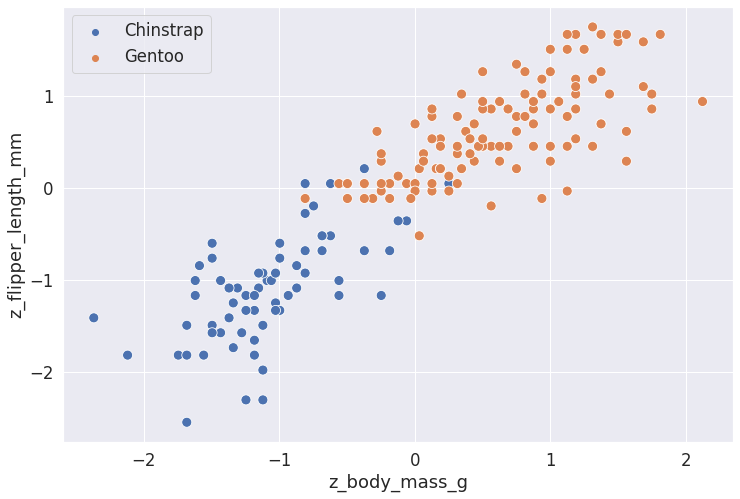

In [4]:
def scatter_penguin_perc(df, circle_bool=None, w_old=None, w=None):
    if circle_bool is None:
        circle_bool = np.ones(df.shape[0], dtype=bool)
        
    df_c = df.loc[circle_bool, :]
    df_x = df.loc[np.logical_not(circle_bool), :]
    
    plt.figure(figsize=(12, 8))
        
    sns.scatterplot(data=df_c, x=x_feat[0], y=x_feat[1], hue='species', s=100, marker='o')
    sns.scatterplot(data=df_x, x=x_feat[0], y=x_feat[1], hue='species', s=100, marker='X', label=None)
    
    def plot_w(w, **kwargs):
        # plot perceptron boundary
        x_series = df.loc[:, x_feat[0]]
        x_min, x_max = x_series.min(), x_series.max()
        x = np.array([x_min, x_max])
        
        m = - w[1] / w[2]
        b = - w[0] / w[2]
        
        boundary = m * x + b
        plt.plot(x, boundary, **kwargs)
    
    if w_old is not None:
        plot_w(w_old, linewidth=2, linestyle='--', color='k', label='old w')
    
    if w is not None:
        plot_w(w, linewidth=2, linestyle='-', color='k', label='w')
        
    plt.legend()        
    
scatter_penguin_perc(df)

In [5]:
def iter_perceptron(x_bias, label, w):
    """ runs a single epoch (though all training data once), returns updated w

    Args:
         x_bias (np.array): (n_sample, n_feature + 1) features (first column is bias)
         label (np.array): (n_sample), boolean class label
         w (np.array): (n_feature) initial perceptron weights
         
    iter:
        row_idx_error (int): index of error row
        w (np.array): (n_feature) after training perception weights
    """    
    # get number of samples and number of features per sample
    n_sample, n_feature = x_bias.shape

    while True:
        # compute p_error, percentage of samples in error
        est = np.dot(x_bias, w) >= 0
        p_error = 1 - (est == label).sum() / n_sample
        
        if not p_error:
            # stop training (all correct)
            break
        
        for idx_sample in range(n_sample):
            # x are the features of a single data point
            x = x_bias[idx_sample, :]

            # classify according to current perception
            y_hat = np.dot(x, w) >= 0            

            # y is the ground truth class label
            y = label[idx_sample]
            
            if y == y_hat:
                continue

            # update
            if y_hat == 0 and y == 1:
                # perceptron estimate: class 0, actual class: 1
                w = w + x
                
            elif y_hat == 1 and y == 0:
                # perceptron estimate: class 1, actual class: 0
                w = w - x
                
            yield idx_sample, w

In [6]:
x_bias = df.loc[:, x_feat].to_numpy()
x_bias = np.hstack((np.ones((x_bias.shape[0], 1)), x_bias))

label = (df.loc[:, 'species'] == species_tup[1]).to_numpy()

### visualizing perceptron learning

<Figure size 864x576 with 0 Axes>

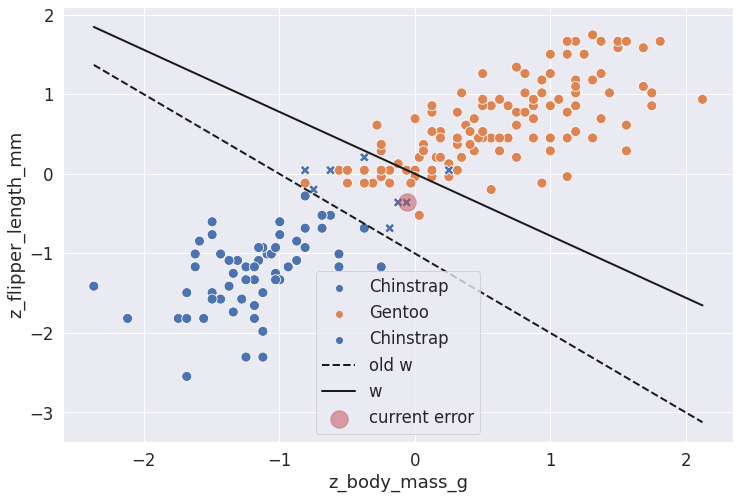

x sample in error: [ 1.         -0.06003653 -0.36029016]
  w (before update): [1 1 1]



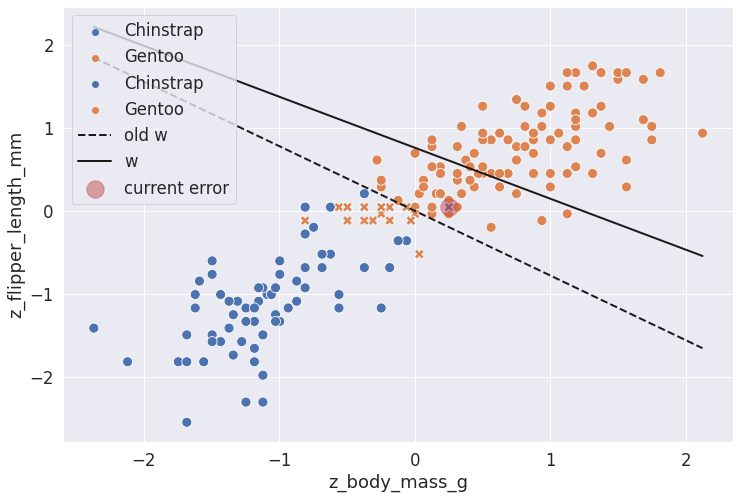

x sample in error: [1.         0.25181988 0.04460323]
  w (before update): [0.         1.06003653 1.36029016]



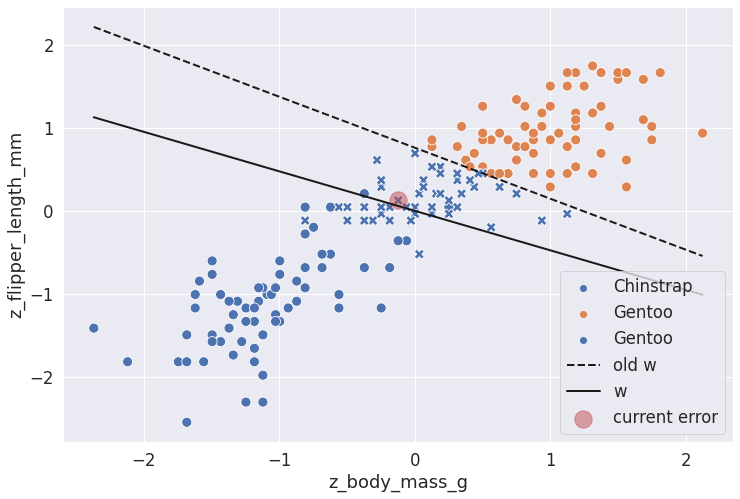

x sample in error: [ 1.         -0.12240781  0.12558191]
  w (before update): [-1.          0.80821665  1.31568693]



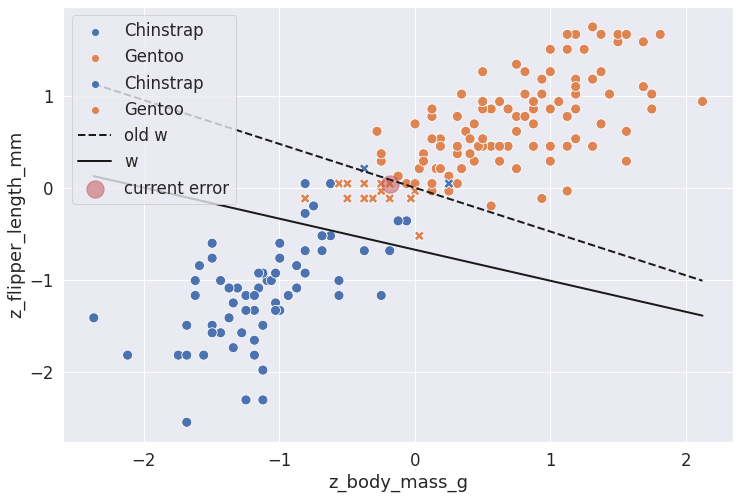

x sample in error: [ 1.         -0.18477909  0.04460323]
  w (before update): [0.         0.68580884 1.44126884]



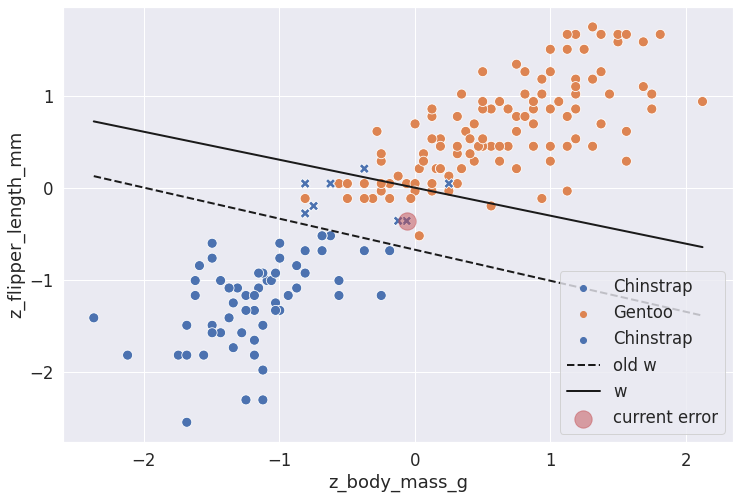

x sample in error: [ 1.         -0.06003653 -0.36029016]
  w (before update): [1.         0.50102975 1.48587207]



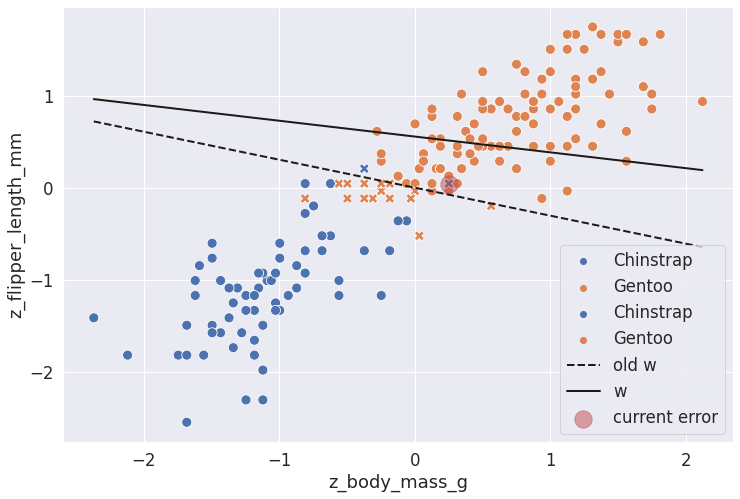

x sample in error: [1.         0.25181988 0.04460323]
  w (before update): [0.         0.56106628 1.84616224]



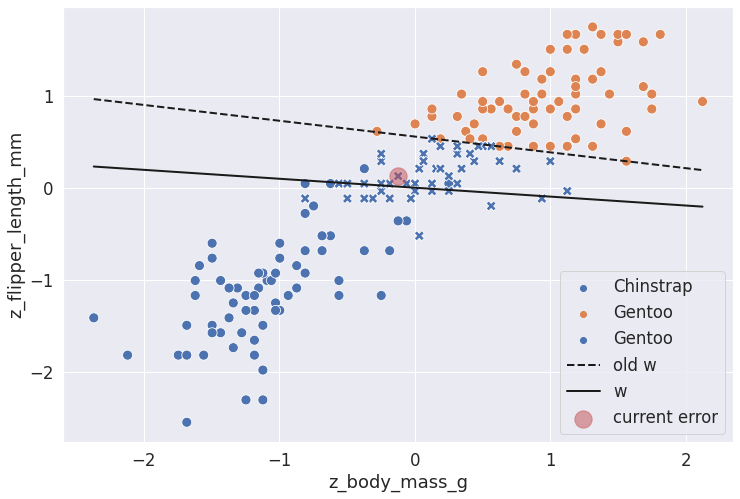

x sample in error: [ 1.         -0.12240781  0.12558191]
  w (before update): [-1.          0.3092464   1.80155901]



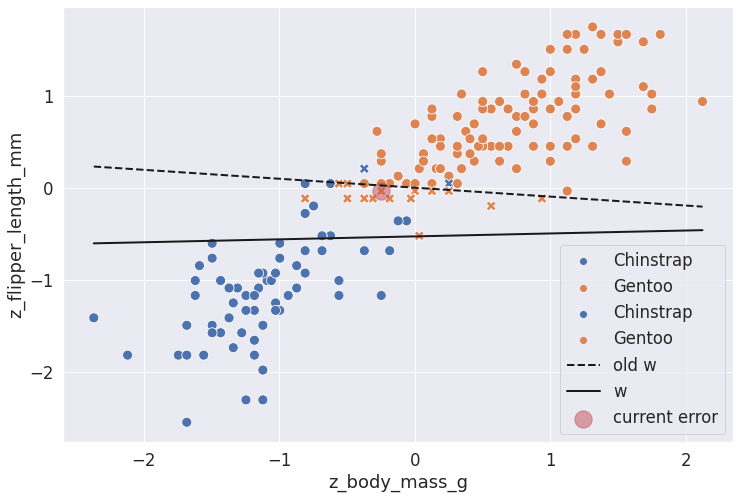

x sample in error: [ 1.         -0.24715037 -0.03637545]
  w (before update): [0.         0.18683859 1.92714092]



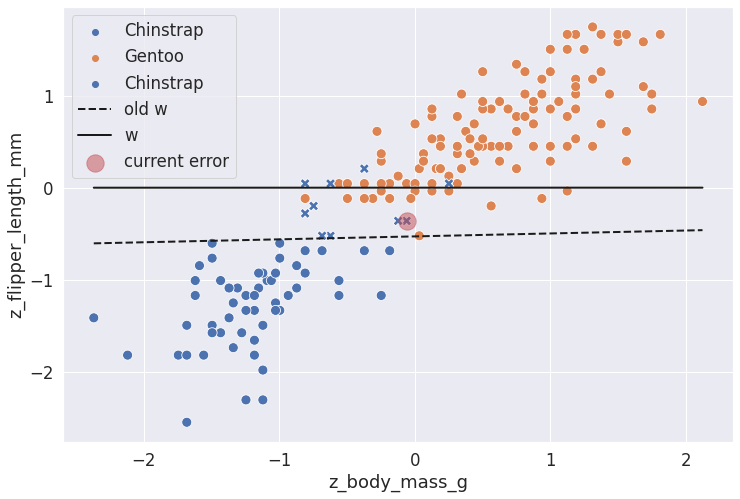

x sample in error: [ 1.         -0.06003653 -0.36029016]
  w (before update): [ 1.         -0.06031178  1.89076547]



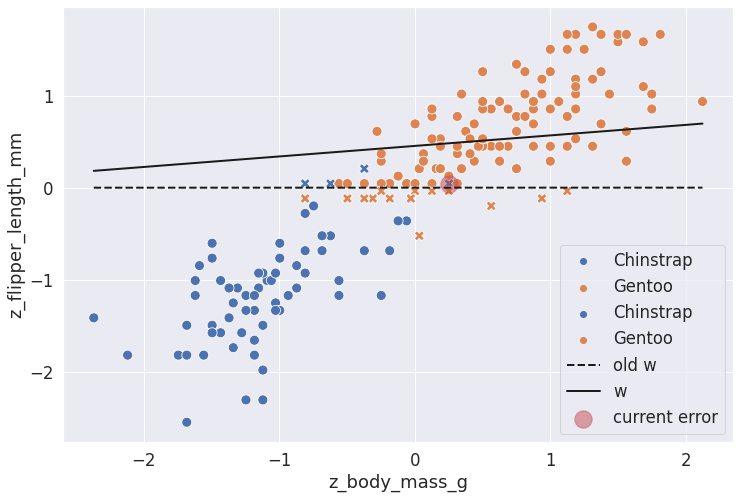

x sample in error: [1.         0.25181988 0.04460323]
  w (before update): [ 0.00000000e+00 -2.75252795e-04  2.25105563e+00]



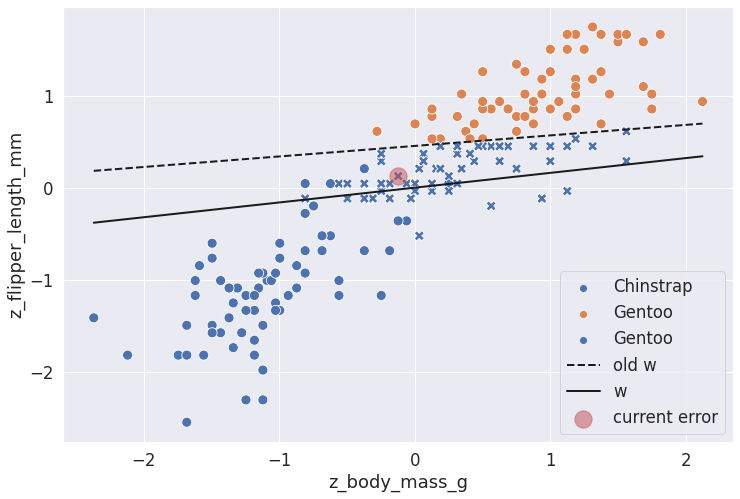

x sample in error: [ 1.         -0.12240781  0.12558191]
  w (before update): [-1.         -0.25209513  2.2064524 ]



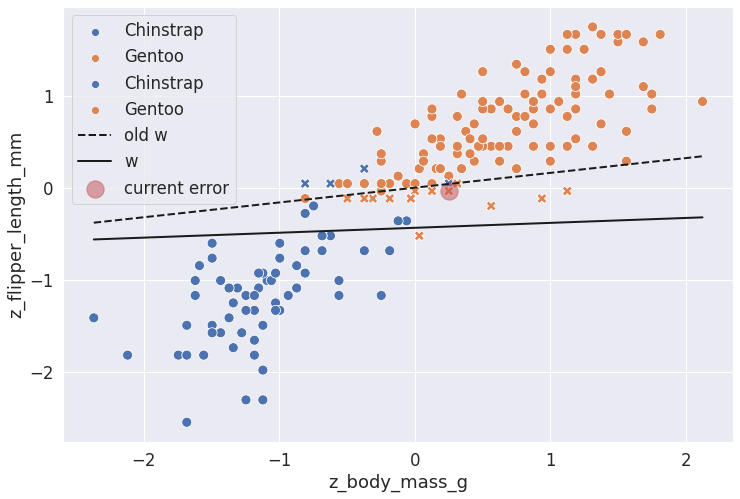

x sample in error: [ 1.          0.25181988 -0.03637545]
  w (before update): [ 0.         -0.37450294  2.33203431]



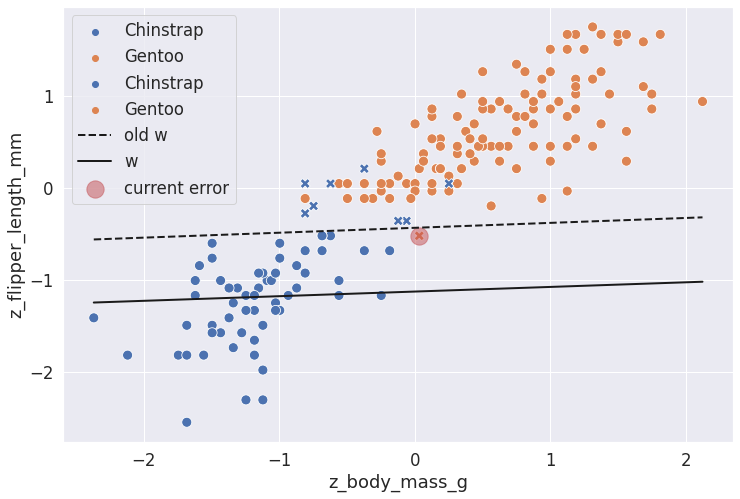

x sample in error: [ 1.          0.03352039 -0.52224752]
  w (before update): [ 1.         -0.12268306  2.29565886]



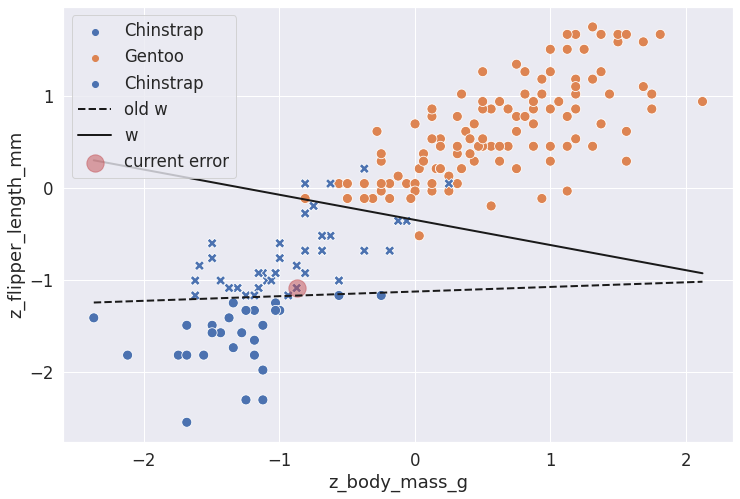

x sample in error: [ 1.         -0.87086318 -1.08909827]
  w (before update): [ 2.         -0.08916267  1.77341134]



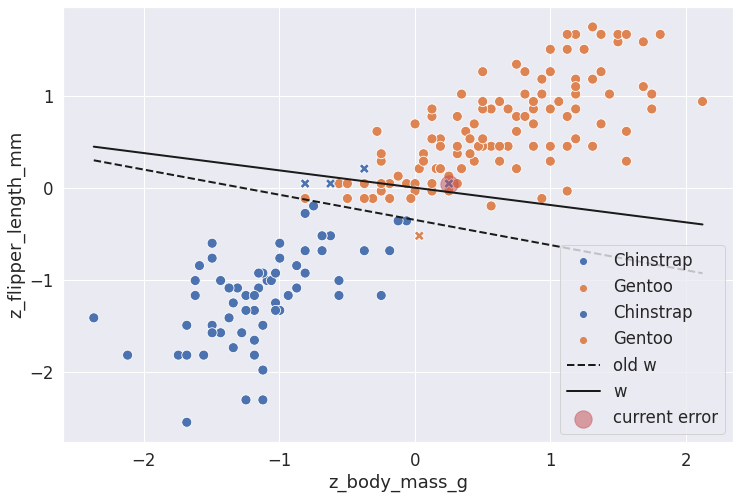

x sample in error: [1.         0.25181988 0.04460323]
  w (before update): [1.         0.78170052 2.86250961]



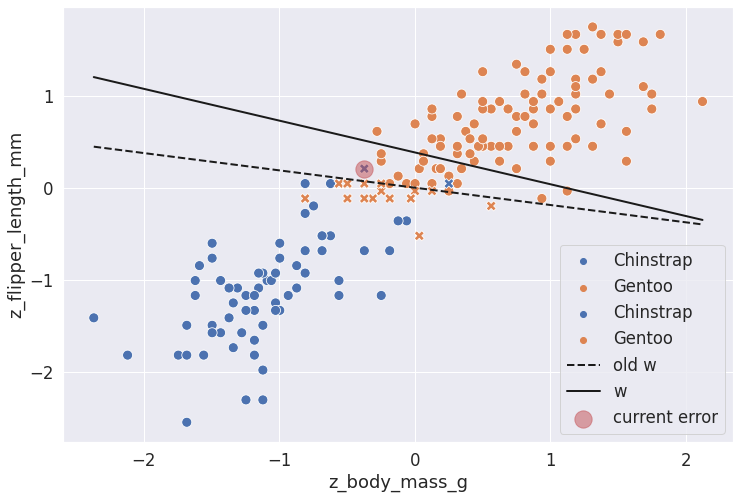

x sample in error: [ 1.         -0.37189293  0.20656059]
  w (before update): [0.         0.52988064 2.81790638]



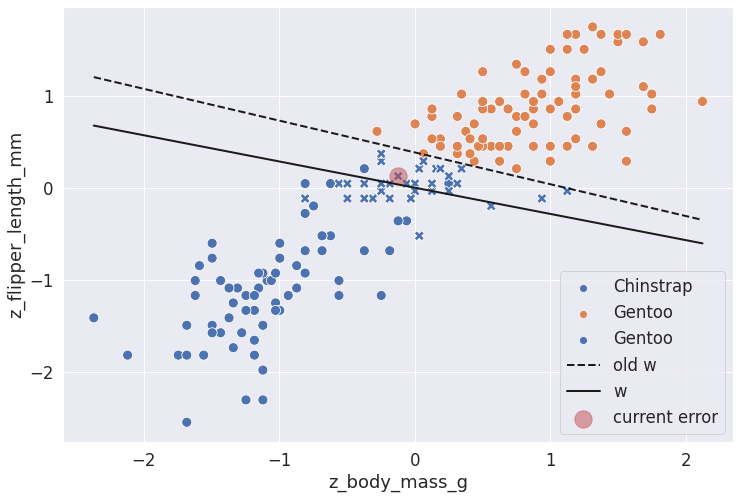

x sample in error: [ 1.         -0.12240781  0.12558191]
  w (before update): [-1.          0.90177357  2.6113458 ]



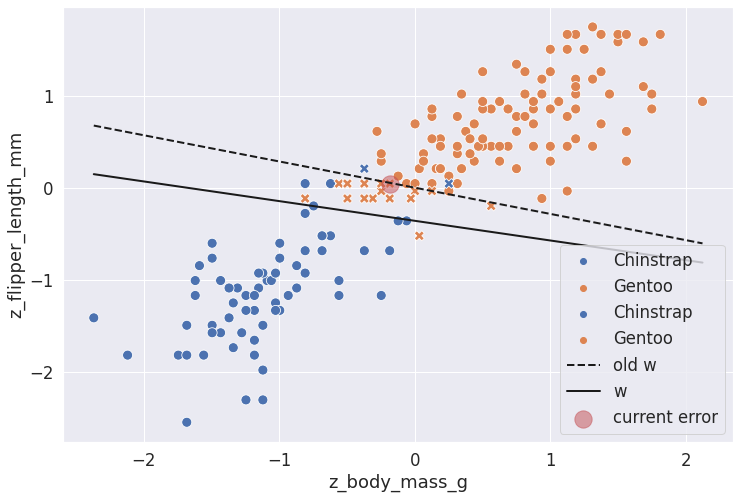

x sample in error: [ 1.         -0.18477909  0.04460323]
  w (before update): [0.         0.77936576 2.7369277 ]



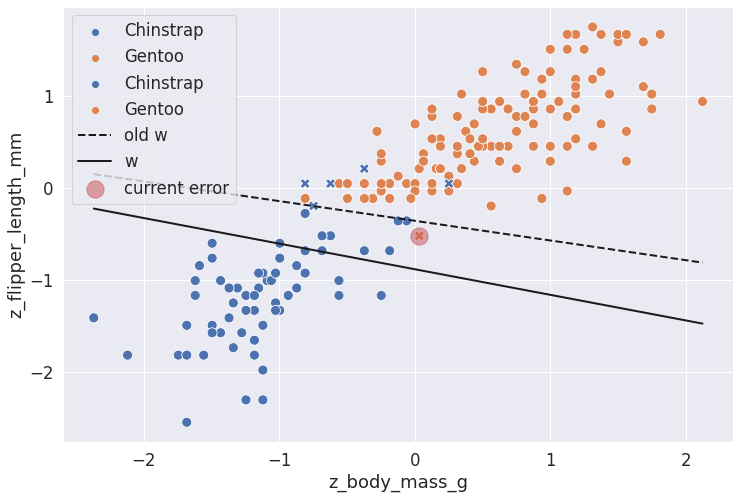

x sample in error: [ 1.          0.03352039 -0.52224752]
  w (before update): [1.         0.59458667 2.78153093]



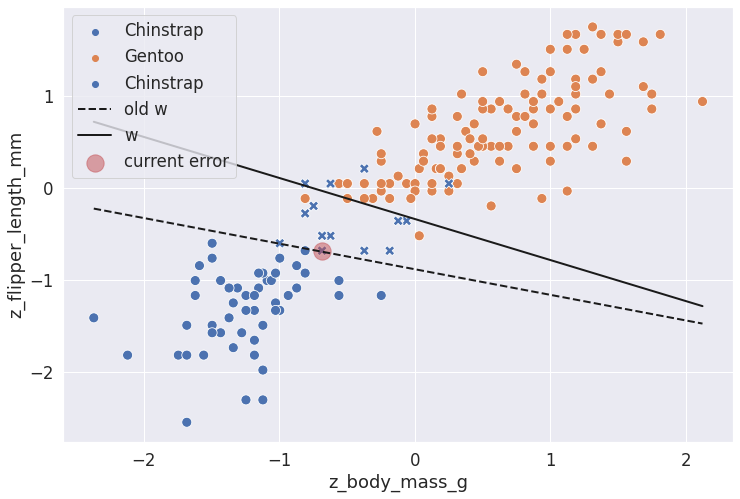

x sample in error: [ 1.         -0.68374934 -0.68420488]
  w (before update): [2.         0.62810707 2.25928341]



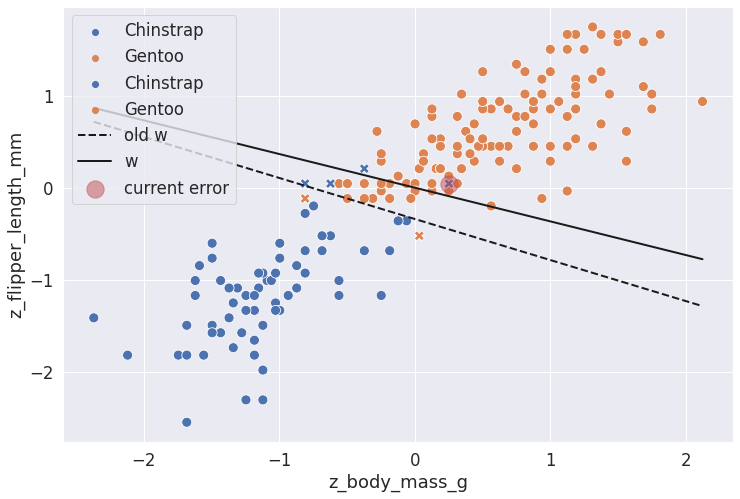

x sample in error: [1.         0.25181988 0.04460323]
  w (before update): [1.         1.31185641 2.94348829]



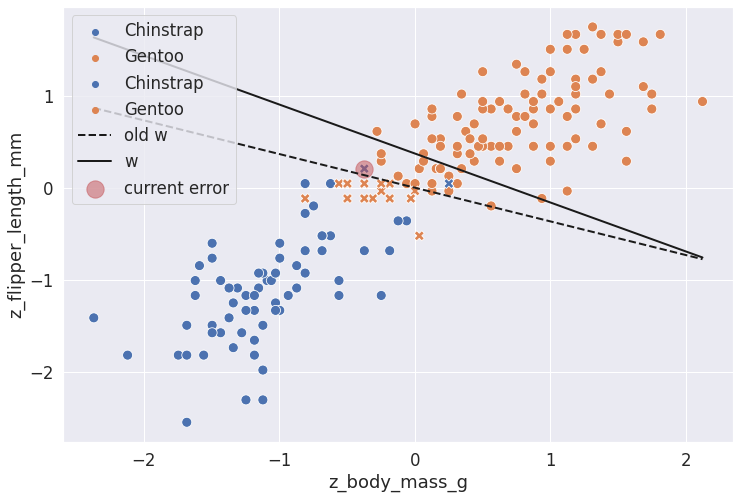

x sample in error: [ 1.         -0.37189293  0.20656059]
  w (before update): [0.         1.06003653 2.89888506]



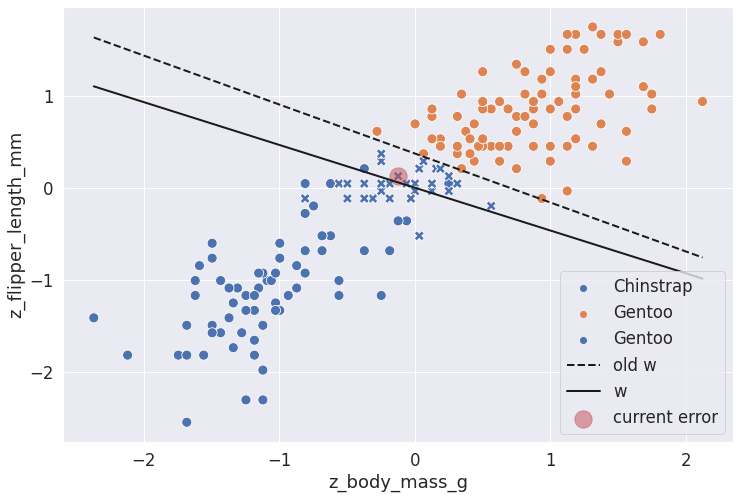

x sample in error: [ 1.         -0.12240781  0.12558191]
  w (before update): [-1.          1.43192946  2.69232447]



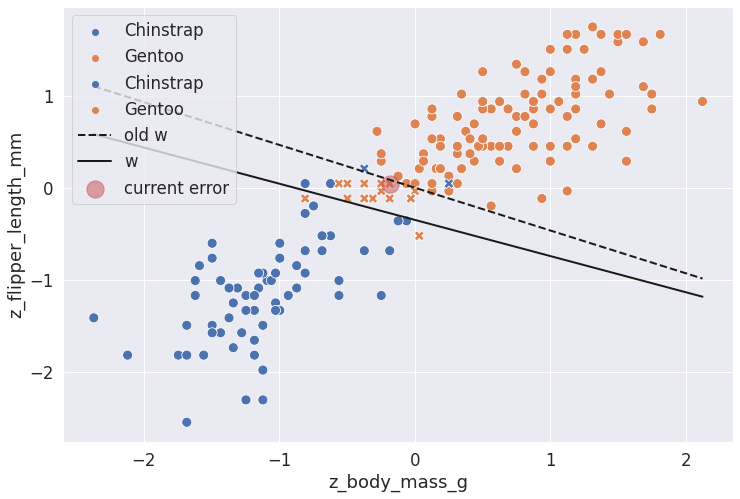

x sample in error: [ 1.         -0.18477909  0.04460323]
  w (before update): [0.         1.30952165 2.81790638]



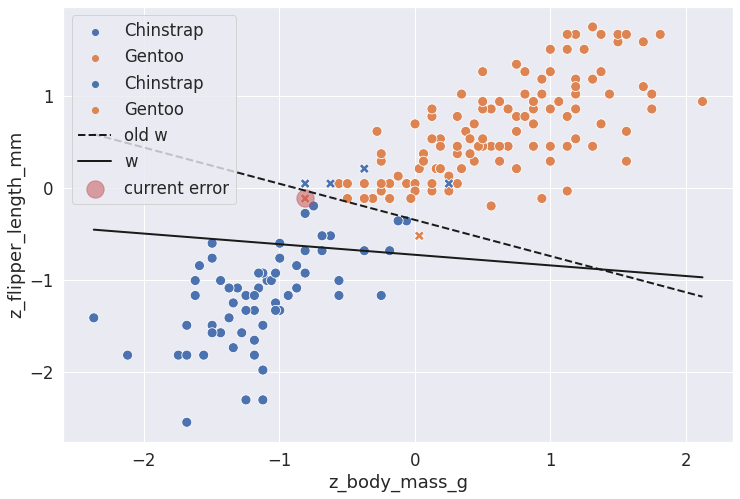

x sample in error: [ 1.         -0.8084919  -0.11735413]
  w (before update): [1.         1.12474256 2.86250961]



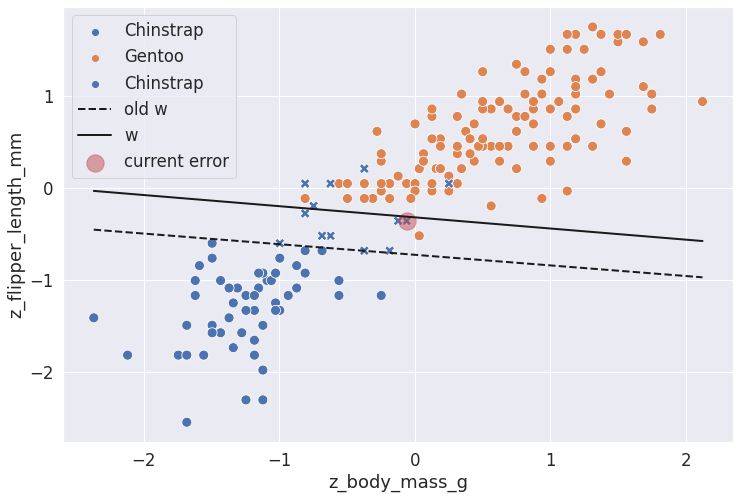

x sample in error: [ 1.         -0.06003653 -0.36029016]
  w (before update): [2.         0.31625066 2.74515548]



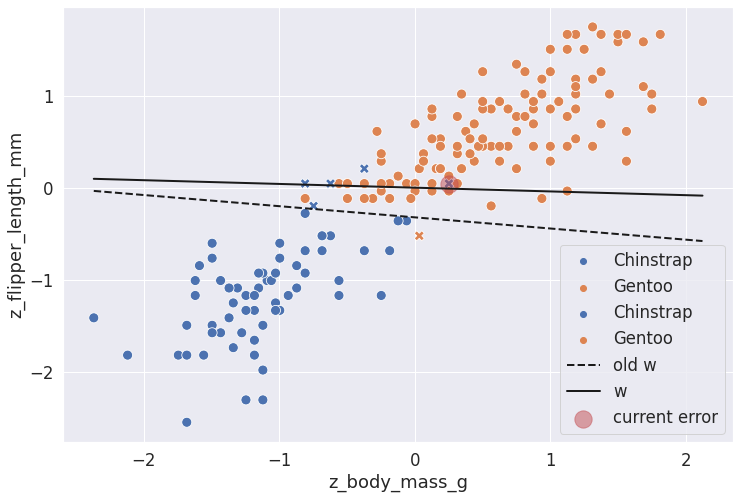

x sample in error: [1.         0.25181988 0.04460323]
  w (before update): [1.         0.37628719 3.10544565]



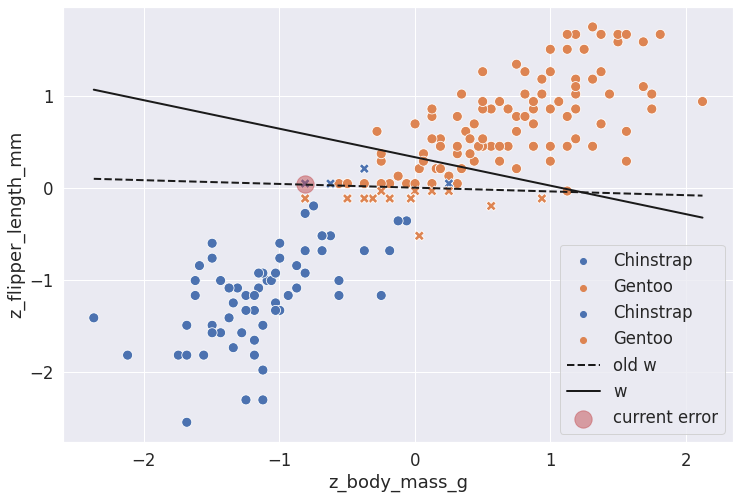

x sample in error: [ 1.         -0.8084919   0.04460323]
  w (before update): [0.         0.12446731 3.06084242]



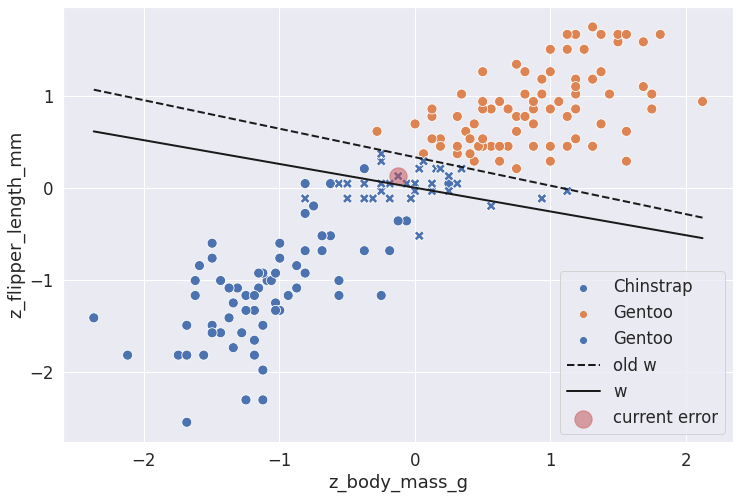

x sample in error: [ 1.         -0.12240781  0.12558191]
  w (before update): [-1.          0.93295921  3.01623919]



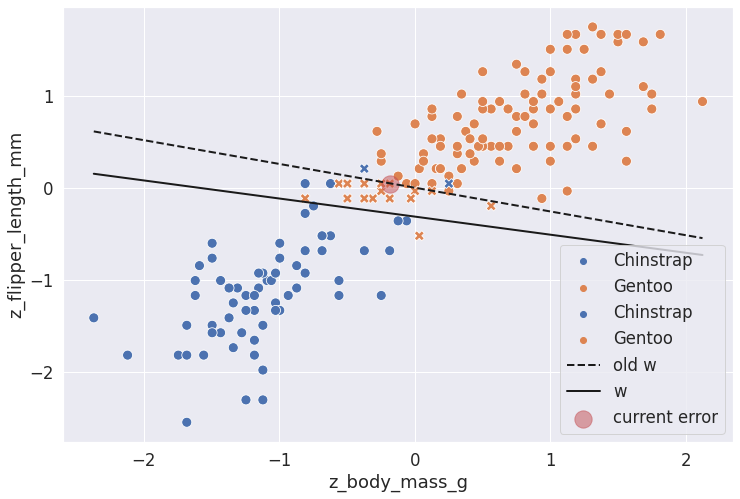

x sample in error: [ 1.         -0.18477909  0.04460323]
  w (before update): [0.        0.8105514 3.1418211]



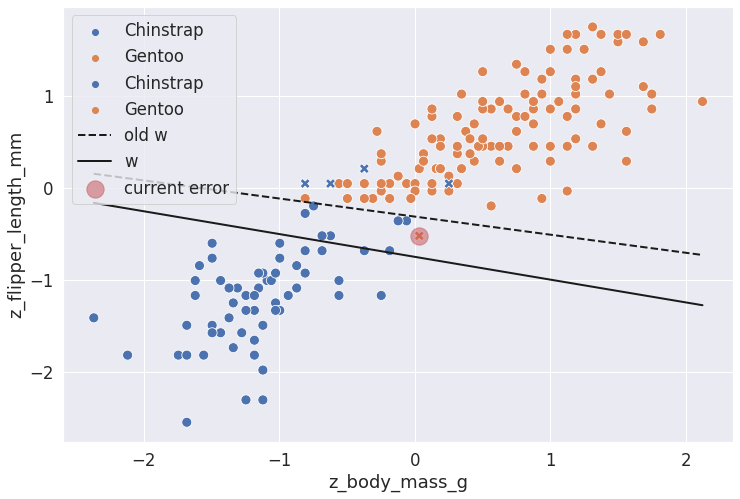

x sample in error: [ 1.          0.03352039 -0.52224752]
  w (before update): [1.         0.62577231 3.18642433]



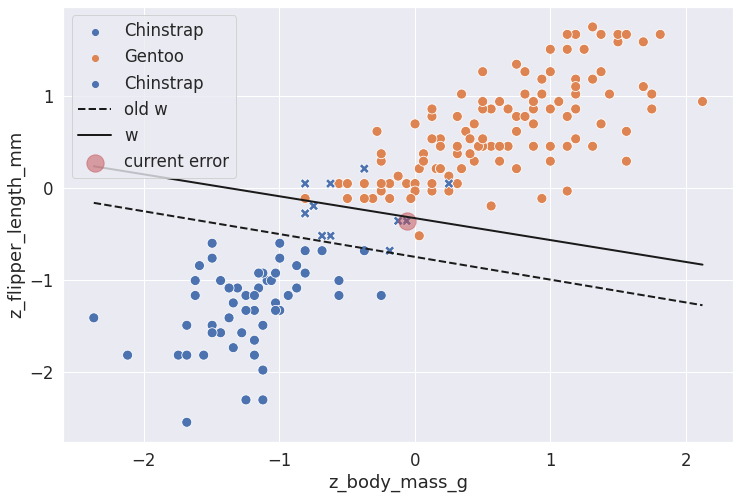

x sample in error: [ 1.         -0.06003653 -0.36029016]
  w (before update): [2.         0.65929271 2.66417681]



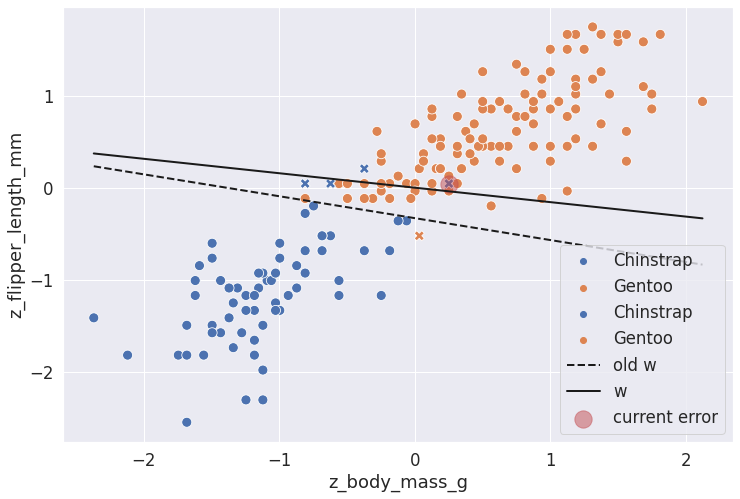

x sample in error: [1.         0.25181988 0.04460323]
  w (before update): [1.         0.71932923 3.02446697]



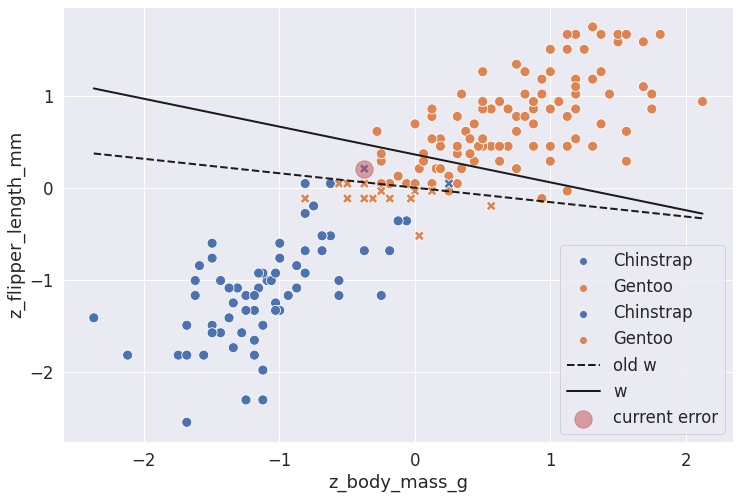

x sample in error: [ 1.         -0.37189293  0.20656059]
  w (before update): [0.         0.46750936 2.97986374]



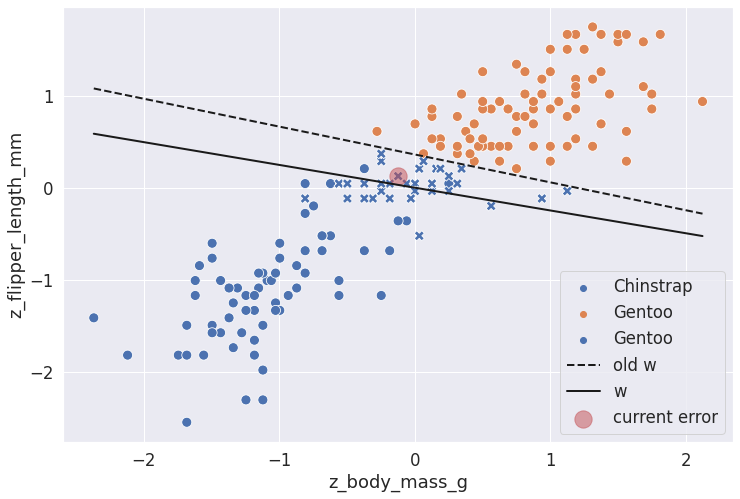

x sample in error: [ 1.         -0.12240781  0.12558191]
  w (before update): [-1.          0.83940229  2.77330315]



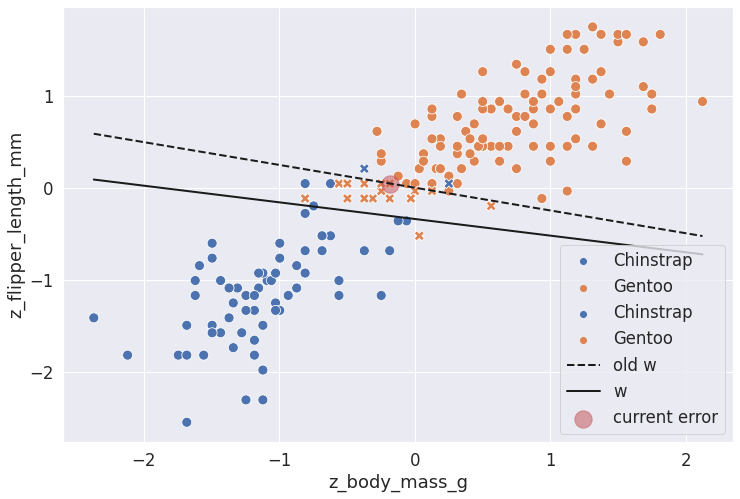

x sample in error: [ 1.         -0.18477909  0.04460323]
  w (before update): [0.         0.71699448 2.89888506]



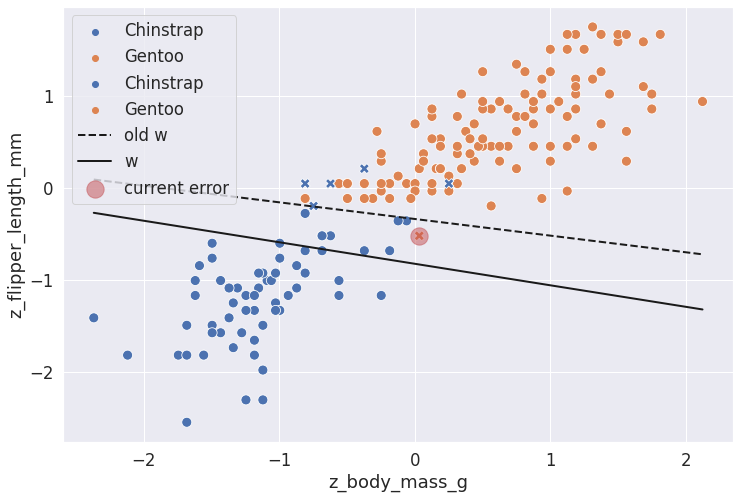

x sample in error: [ 1.          0.03352039 -0.52224752]
  w (before update): [1.         0.53221539 2.94348829]



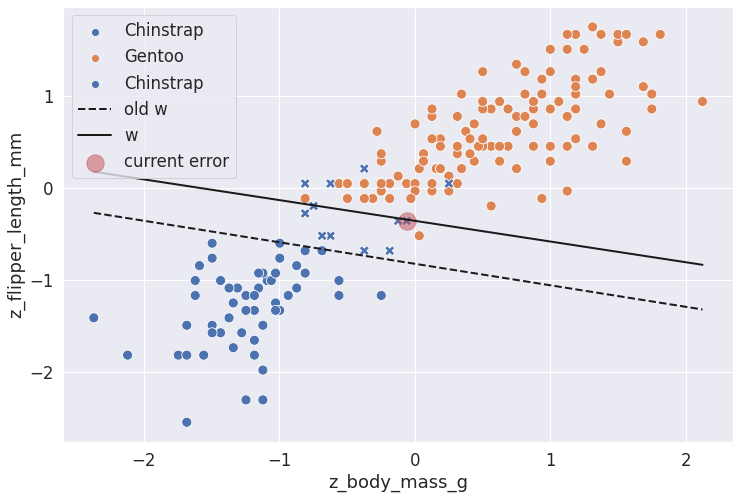

x sample in error: [ 1.         -0.06003653 -0.36029016]
  w (before update): [2.         0.56573579 2.42124077]



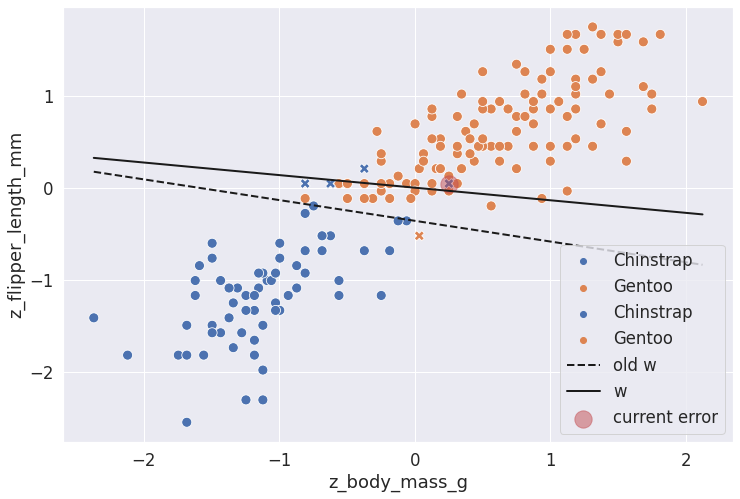

x sample in error: [1.         0.25181988 0.04460323]
  w (before update): [1.         0.62577231 2.78153093]



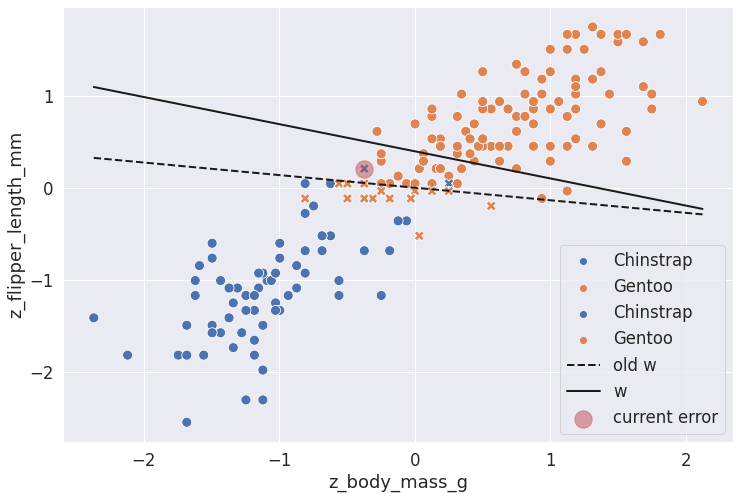

x sample in error: [ 1.         -0.37189293  0.20656059]
  w (before update): [0.         0.37395243 2.7369277 ]



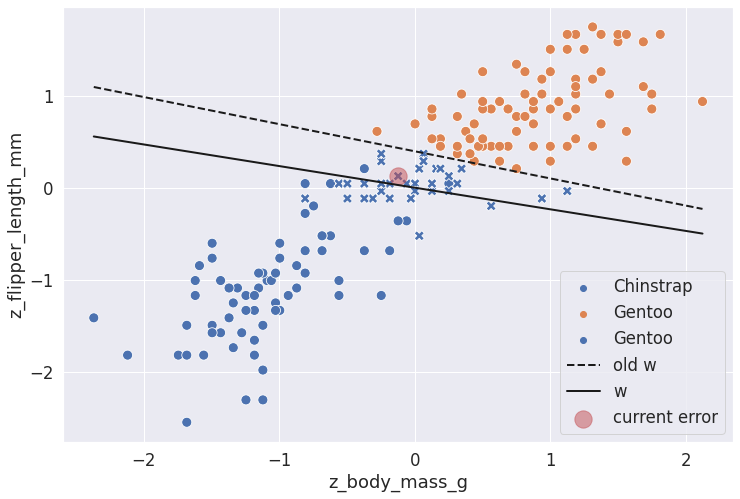

x sample in error: [ 1.         -0.12240781  0.12558191]
  w (before update): [-1.          0.74584537  2.53036712]


In [ ]:
# an arbitrary initialization
w_old = np.array([1, 1, 1])
plt.figure(figsize=(12, 8))

# todo bug: only 1 color if all samples on one side of perceptron
# todo bug: legend has entries per x's and o's ... somehow all show up as o's

for idx_error, w_new in iter_perceptron(x_bias, label, w_old):    
    correct_bool = (np.dot(x_bias, w_old) >= 0) == label
    scatter_penguin_perc(df, w_old=w_old, w=w_new, circle_bool=correct_bool)
    
    # highlight the error being corrected for
    plt.scatter(x_bias[idx_error, 1], x_bias[idx_error, 2], color='r', alpha=.5, s=300, label='current error')
    
    plt.legend()    
    plt.show()
    
    print(f'x sample in error: {x_bias[idx_error, :]}\n  w (before update): {w_old}')
    
    w_old = w_new
    
    if input() == 'stop':
        break
